<a href="https://colab.research.google.com/github/chanzae/NLP_study/blob/main/14_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT(Bidirectional Encoder Representations from Transformers)

* 참고: https://ebbnflow.tistory.com/151
* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

## Input Representation

* 3가지의 입력 임베딩(Token, Segment, Position 임베딩)의 합으로 구성

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbABsUL%2FbtqzmTU7OLm%2FYwK6JLhNfTYvxkiFzkfkCK%2Fimg.png)

### Token Embeddings

* Word Piece 임베딩 방식 사용
* 자주 등장하면서 가장 긴 길이의 sub-word를 하나의 단위로 생성
* 즉, 자주 등장하는 sub-word은 그 자체가 단위가 되고, 자주 등장하지 않는 단어(rare word)는 sub-word로 쪼개짐
* 기존 워드 임베딩 방법은 Out-of-vocabulary (OOV) 문제가 존재하며, 희귀 단어, 이름, 숫자나 단어장에 없는 단어에 대한 학습, 번역에 어려움이 있음
* Word Piece 임베딩은 모든 언어에 적용 가능하며, sub-word 단위로 단어를 분절하므로 OOV 처리에 효과적이고 정확도 상승효과도 있음


### Sentence Embeddings

* BERT는 두 개의 문장을 문장 구분자([SEP])와 함께 결합
* 입력 길이의 제한으로 두 문장은 합쳐서 512 subword 이하로 제한
* 입력의 길이가 길어질수록 학습시간은 제곱으로 증가하기 때문에 적절한 입력 길이 설정 필요
* 한국어는 보통 평균 20 subword로 구성되고 99%가 60 subword를 넘지 않기 때문에 입력 길이를 두 문장이 합쳐 128로 해도 충분
* 간혹 긴 문장이 있으므로 우선 입력 길이 128로 제한하고 학습한 후, 128보다 긴 입력들을 모아 마지막에 따로 추가 학습하는 방식을 사용


### Position Embedding

* BERT는 저자의 이전 논문인 Transformer 모델을 착용
* Transformer은 주로 사용하는 CNN, RNN 모델을 사용하지 않고 Self-Attention 모델을 사용
* Self-Attention은 입력의 위치에 대해 고려하지 못하므로 입력 토큰의 위치 정보가 필요
* Transformer 에서는 Sinusoid 함수를 이용한 Positional encoding을 사용하였고, BERT에서는 이를 변형하여 Position encoding을 사용
* Position encoding은 단순하게 Token 순서대로 0, 1, 2, ...와 같이 순서대로 인코딩


### 임베딩 취합

* BERT는 위에서 소개한 3가지의 입력 임베딩(Token, Segment, Position 임베딩)을 취합하여 하나의 임베딩 값으로 생성
* 임베딩의 합에 Layer Normalization과 Dropout을 적용하여 입력으로 사용

## 언어 모델링 구조(Pre-training BERT)

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbg5SlP%2FbtqzntBU7Uj%2FKHWiKI4zKgb8FqLzAYAusK%2Fimg.png)

### 언어 모델링 데이터

* BERT는 총 3.3억 단어(8억 단어의 BookCorpus 데이터와 25억 단어의 Wikipedia 데이터)의 거대한 말뭉치를 이용하여 학습
* 거대한 말뭉치를 MLM, NSP 모델 적용을 위해 스스로 라벨을 만들고 수행하므로 준지도학습(Semi-supervised)이라고 함
* Wikipedia와 BookCorpus를 정제하기 위해 list, table, header를 제거
* 문장의 순서를 고려해야 하므로 문단 단위로 분리하였고 많은 데이터 정제 작업을 수행

### 모델 구조

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbL28Ok%2FbtqznO6UmYw%2Fe0mFyA814Pvj4kltVxKls0%2Fimg.png)


* BERT 모델은 Transformer를 기반으로 함
* Transformer 모델 구조는 인코더-디코더 모델이며 번역 도메인에서 최고 성능을 기록
* 기존 인코더-디코더 모델들과 다르게 Transformer는 CNN, RNN을 이용하지 않고 Self-attention이라는 개념을 도입
* BERT는 Transformer의 인코더-디코더 중 인코더만 사용하는 모델

### MLM(Masked Language Model)

* 입력 문장에서 임의로 Token을 마스킹(masking), 그 Token을 맞추는 방식인 MLM 학습 진행
* 문장의 빈칸 채우기 문제를 학습

* 생성 모델 계열은(예를들어 GPT) 입력의 다음 단어를 예측
* MLM은 문장 내 랜덤한 단어를 마스킹 하고 이를 예측
* 입력의 15% 단어를 [MASK] Token으로 바꿔주어 마스킹
* 이 때 80%는 [MASK]로 바꿔주지만, 나머지 10%는 다른 랜덤 단어로, 또 남은 10%는 바꾸지 않고 그대로 둠
* 이는 미세 조정 시 올바른 예측을 돕도록 마스킹에 노이즈를 섞음

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FLMyXN%2Fbtqzl4Ql7sH%2FykzRZNWkc6rcb8ffU5Nrm1%2Fimg.png)

* 아래 그림은 MLM의 학습 과정
* 입력 단어의 15%가 [MASK]로 대체된 입력이 들어가고, MLM은 [MASK]가 어떤 단어인지를 예측
* BERT의 Token 임베딩은 Word Piece 임베딩 방식을 사용하고, Word piece의 단어수는 30522 단어
* 3만 단어 중 [MASK]에 들어갈 단어를 찾는 것이므로 MLM의 출력인 Softmax의 클래스는 3만개

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fc0lfDS%2FbtqzmTOp4JK%2FXkDq157Mw7MnycHeC2NAx1%2Fimg.png)

### NSP(Next Sentence Prediction)

* NSP는 두 문장이 주어졌을 때 두 번째 문장이 첫 번째 문장의 바로 다음에 오는 문장인지 여부를 예측하는 방식
* 두 문장 간 관련이 고려되어야 하는 NLI와 QA의 파인튜닝을 위해 두 문장이 연관이 있는지를 맞추도록 학습
* 아래 그림은 NSP의 입력 예시
* 위에서 설명한 MLM과 동시에 NSP도 적용된 문장들
* 첫 번째 문장과 두 번째 문장은 [SEP]로 구분
* 두 문장이 실제로 연속하는지는 50% 비율로 참인 문장과, 50%의 랜덤하게 추출된 상관 없는 문장으로 구성
* 이 학습을 통해 문맥과 순서를 언어모델이 학습 가능

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FmRPzz%2Fbtqzps28Eyd%2F2ak5AHBLlk1jXHnOgGwyMK%2Fimg.png)

* 아래 그림은 NSP의 학습 방법
* 연속 문장인지, 아닌지만 판단하면 되므로 Softmax의 출력은 2개이고 3만개의 출력을 갖는 MLM에 비해 빠르게 학습

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlyapH%2FbtqzmkrVtki%2FUUqjexLh7Lt4ZwMVpjIBJ1%2Fimg.png)

## 학습된 언어모델 전이학습(Transfer Learning)

* 파인 튜닝은 학습된 언어 모델을 이용하여 실제 자연어처리 문제를 푸는 과정
* 실질적으로 성능이 관찰되는 것은 전이학습 이지만, 언어 모델이 제대로 학습되야 전이학습 시 좋은 성능이 나옴
* 기존 알고리즘들은 자연어의 다양한 Task에 각각의 알고리즘을 독립적으로 만들어야 했지만, BERT 개발 이후 많은 자연어처리 연구자들은 언어 모델을 만드는데 더 공을 들이게 됨
* 전이학습 Task의 성능도 훨씬 더 좋아짐
* 전이학습은 라벨이 주어지므로 지도학습(Supervised learning)

* 전이학습은 BERT의 언어 모델의 출력에 추가적인 모델을 쌓아서 사용
* 일반적으로 복잡한 CNN, LSTM, Attention을 쌓지 않고 간단한 DNN만 쌓아도 성능이 잘 나오며 별 차이가 없다고 알려짐

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdHqgat%2Fbtqzl4CSqNd%2F7q3g5hxTcAENvvcu1wK6KK%2Fimg.png)

## BERT 친구들

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbMaiOM%2FbtqznO6UO3m%2FwvMAVAZDLngmplVbkn0gqK%2Fimg.jpg)

# BERT 네이버 영화 리뷰 분류

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

## 라이브러리

In [9]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tqdm import tqdm
import tensorflow as tf
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

## 데이터 다운로드

In [11]:
tf.random.set_seed(111)
np.random.seed(111)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [12]:
import urllib.request
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [6]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## BertTokenizer

* 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir = 'bert_ckpt', do_lower_case = False)
def bert_tokenizer(sentence, MAX_LEN):

  encoded_dict = tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,
      max_length = MAX_LEN,
      pad_to_max_length = True,
      return_attention_mask = True
  )

  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

In [17]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sentence, train_label in tqdm(zip(train_data['document'], train_data['label']), total = len(train_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_labels.append(train_label)

  except Exception as e:
    print(e)
    pass

train_movie_input_ids = np.array(input_ids, dtype = int)
train_movie_attention_masks = np.array(attention_masks, dtype = int)
train_movie_token_type_ids = np.array(token_type_ids, dtype = int)
train_movie_input = (train_movie_input_ids,train_movie_attention_masks,train_movie_token_type_ids)
train_data_labels = np.array(train_data_labels, dtype = np.int32)

print(f"Sentences : {len(train_movie_input_ids)}\nLabels : {len(train_data_labels)}")

100%|██████████| 149995/149995 [00:40<00:00, 3723.62it/s]


Sentences : 149995
Labels : 149995


In [20]:
idx = 5
input_id = train_movie_input_ids[idx]
attention_mask = train_movie_attention_masks[idx]
token_type_id = train_movie_token_type_ids[idx]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9247   8867  32158  23811    100    124  24982  17655   9757
  55511    122  23321  10954  24017  12030    129 106249  24974  30858
  18227    119    100    119    119    119   9353  30134  21789  12092
   9519 118671 119169    119    102      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] 막 걸음마 [UNK] 3세부터 초등학교 1학년생인 8살용영화. [UNK]... 별반개도 아까움. [SEP] [PAD] [PAD] [PAD] [PAD]


In [37]:
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()

    self.bert = TFBertModel.from_pretrained(model_name, cache_dir = dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class,
                                            kernel_initializer = tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name = 'classifier')
    
  def call(self, inputs, attention_mask = None, token_type_ids = None, training = False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids = token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training = training)
    logits = self.classifier(pooled_output)

    return logits

cls_model = TFBertClassifier(model_name = 'bert-base-multilingual-cased',
                             dir_path = 'bert_ckpt',
                             num_class = 2)

## 모델 학습

In [38]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss = loss, metrics = [metric])

In [40]:
model_name = 'tf2_bert_naver_movie'

es_callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 2)

checkpoint_path = os.path.join('./', model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_path):
  print(f'{checkpoint_dir} Directory already exists\n')
else:
  os.makedirs(checkpoint_dir, exist_ok = True)
  print(f'{checkpoint_dir} Directory create complete\n')

cp_callback = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',
                              verbose = 1, save_best_only = True, save_weights_only = True)

history = cls_model.fit(train_movie_input, train_data_labels,
                        epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, validation_split = VALID_SPLIT,
                        callbacks = [es_callback, cp_callback])

print(history.history)

./tf2_bert_naver_movie Directory create complete

Epoch 1/3
3750/3750 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8598
Epoch 00001: val_accuracy improved from -inf to 0.85386, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 1217s 325ms/step - loss: 0.3221 - accuracy: 0.8598 - val_loss: 0.3367 - val_accuracy: 0.8539
Epoch 2/3
3750/3750 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.8859
Epoch 00002: val_accuracy improved from 0.85386 to 0.85470, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 1221s 325ms/step - loss: 0.2721 - accuracy: 0.8859 - val_loss: 0.3440 - val_accuracy: 0.8547
Epoch 3/3
3750/3750 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9111
Epoch 00003: val_accuracy improved from 0.85470 to 0.85760, saving model to ./tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 1223s 326ms

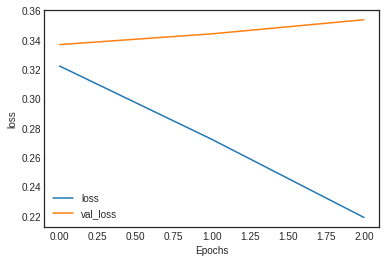

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.show()


## 모델 평가

In [42]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence, test_label in tqdm(zip(test_data['document'], test_data['label'])):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    test_data_labels.append(test_label)

  except Exception as e:
    print(e)
    pass

test_movie_input_ids = np.array(input_ids, dtype = int)
test_movie_attention_masks = np.array(attention_masks, dtype = int)
test_movie_token_type_ids = np.array(token_type_ids, dtype = int)
test_movie_input = (test_movie_input_ids,test_movie_attention_masks,test_movie_token_type_ids)
test_data_labels = np.array(test_data_labels, dtype = np.int32)

49997it [00:17, 2932.03it/s]


In [43]:
cls_model.evaluate(test_movie_input, test_data_labels, batch_size = 1024)

49/49 [==============================] - 121s 2s/step - loss: 0.3579 - accuracy: 0.8544


[0.3578644096851349, 0.854351282119751]